In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import display, clear_output

In [2]:
from functools import partial
import random
import pickle

import numpy as np
from PIL import Image

from utils import min_max_slice, slice_centered_in, coordinates, random_sample, constrain_index, convert_to_image
from image_completion import preprocess_image, find_edge, compute_ssd, copy_patch, fill_hole

## constants

In [3]:
PATCH_LEN = 10
PATCH_SELECTION_STD = 3

In [4]:
IMAGE_PATH  = 'examples/Denim.jpg'                 # what to fill
HOLE_PATH   = 'examples/Denim_fill_region.pkl'     # where to fill
SEARCH_PATH = 'examples/Denim_texture_region.pkl'  # where to look for matching texture

In [5]:
slice_centered_in_ = partial(slice_centered_in, length=PATCH_LEN)
compute_ssd_ = partial(compute_ssd, patch_len=PATCH_LEN)
copy_patch_ = partial(copy_patch, patch_len=PATCH_LEN)

## open

In [6]:
im, hole_mask, punctured_im, searchable, searchable_mask = preprocess_image(IMAGE_PATH, HOLE_PATH, SEARCH_PATH, PATCH_LEN)

original image, size (200, 125)


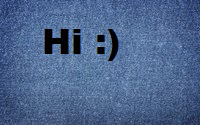

In [7]:
print('original image, size', im.size)
im

where to replace:


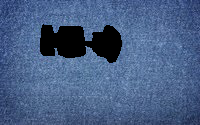

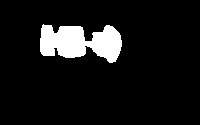

In [8]:
print('where to replace:')
display(convert_to_image(punctured_im))
display(convert_to_image(hole_mask))

where to seek a match:


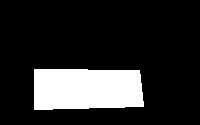

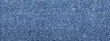

In [9]:
print('where to seek a match:')
display(convert_to_image(searchable_mask))
display(convert_to_image(searchable))

---

## step by step

candidates lie on the edge of the hole:


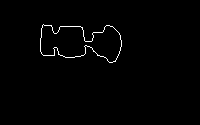

In [10]:
on_edge_mask = find_edge(hole_mask)

print('candidates lie on the edge of the hole:')
convert_to_image(on_edge_mask)

In [11]:
# pick a random pixel on the edge to be the center of the patch to fill
patch_to_fill_center = random_sample(zip(*on_edge_mask.nonzero()))
patch_to_fill = punctured_im[slice_centered_in_(patch_to_fill_center)]
is_fillable_mask = hole_mask[slice_centered_in_(patch_to_fill_center)]

print('patch to fill:') 
display(convert_to_image(patch_to_fill))

print('\nwhere to fill (black):') 
display(convert_to_image(is_fillable_mask))

patch to fill:



where to fill (black):


---

In [12]:
%time ssd_matrix = compute_ssd_(patch_to_fill, searchable, is_fillable_mask)

CPU times: user 1.41 s, sys: 14.8 ms, total: 1.42 s
Wall time: 1.42 s


In [13]:
print('heatmap of distances from target patch to candidates in the searchable area:')
convert_to_image(ssd_matrix)

heatmap of distances from target patch to candidates in the searchable area:


---

In [14]:
# select closest patch (with a bit of stochasticity)
indices_of_closest = ssd_matrix.argsort(axis=None)  # on the raveled matrix
selected_pos = constrain_index(random.gauss(0, PATCH_SELECTION_STD), len(indices_of_closest))
match_center = np.unravel_index(indices_of_closest[selected_pos], ssd_matrix.shape)
match_center = (match_center[0] + PATCH_LEN, match_center[1] + PATCH_LEN)

In [15]:
print('texture patch selected as best:')
convert_to_image(searchable[slice_centered_in_(match_center)])

texture patch selected as best:


---

before:


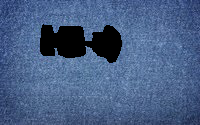


after:


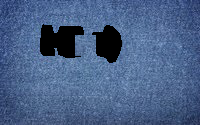

In [16]:
print('before:')
display(convert_to_image(punctured_im))

copy_patch_(punctured_im, patch_to_fill_center, searchable, match_center, is_fillable_mask)

print('\nafter:')
display(convert_to_image(punctured_im))

In [17]:
# since we just filled it, the pixels in the patch are neither empty, nor on the edge
hole_mask[slice_centered_in_(patch_to_fill_center)] = False
on_edge_mask[slice_centered_in_(patch_to_fill_center)] = False

## movie

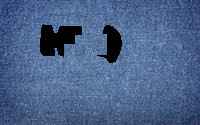

1407 pixels left to fill


In [18]:
for punctured_im, hole_mask in fill_hole(hole_mask, punctured_im, searchable, PATCH_LEN, PATCH_SELECTION_STD):
    clear_output()
    display(convert_to_image(punctured_im))
    print(hole_mask.sum(), 'pixels left to fill')

## result

In [ ]:
convert_to_image(punctured_im)